# Код для повторения на Kaggle

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")


set_seed(42)

Random seed set as 42


# Загрузка датасета

In [3]:
# Для Kaggle
import kagglehub

path = kagglehub.dataset_download("andrewmvd/trip-advisor-hotel-reviews")

df = pd.read_csv("/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv")

df.head()

In [4]:
# Локально
df = pd.read_csv("tripadvisor_hotel_reviews.csv")

df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
df.shape

(20491, 2)

In [6]:
df["Rating"].value_counts().sort_index()

Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: count, dtype: int64

# Подготовка данных

In [7]:
class HotelReviewsDataset(Dataset):
    def __init__(self, reviews, ratings, tokenizer, max_length=128):
        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        rating = self.ratings[idx]

        encoded = self.tokenizer.encode_plus(
            review,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt",
            return_attention_mask=True,
        )

        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": torch.tensor(rating - 1, dtype=torch.long),
        }

In [8]:
X = df["Review"].values
y = df["Rating"].values

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=12
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=12
)

In [9]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

train_dataset = HotelReviewsDataset(X_train, y_train, tokenizer)
val_dataset = HotelReviewsDataset(X_val, y_val, tokenizer)
test_dataset = HotelReviewsDataset(X_test, y_test, tokenizer)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [11]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes=5):
        super(CNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.conv1 = nn.Conv1d(embed_dim, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(256)
        self.conv2 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)

        x = self.pool(x).squeeze(-1)
        x = self.dropout2(x)
        x = self.fc(x)

        return x

In [12]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True
        )
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, attention_mask=None):
        embedded = self.embedding(x)

        if attention_mask is not None:
            embedded = embedded * attention_mask.unsqueeze(-1)

        lstm_out, _ = self.lstm(embedded)

        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)

        x = self.dropout(context_vector)
        x = self.fc(x)

        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [13]:
def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=5)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Эпоха {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [14]:
vocab_size = tokenizer.vocab_size

embed_dim = 128
hidden_dim = 256
num_classes = 5

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
cnn_model = CNNClassifier(vocab_size, embed_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5)

In [17]:
cnn_results = train_model(
    cnn_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
    device=device,
)

Эпоха 1/25:
Train Loss: 1.5672, Train Accuracy: 37.21%
Val Loss: 1.3775, Val Accuracy: 44.14%
Эпоха 2/25:
Train Loss: 1.4635, Train Accuracy: 39.03%
Val Loss: 1.3259, Val Accuracy: 44.70%
Эпоха 3/25:
Train Loss: 1.3784, Train Accuracy: 41.87%
Val Loss: 1.2274, Val Accuracy: 47.27%
Эпоха 4/25:
Train Loss: 1.2841, Train Accuracy: 45.01%
Val Loss: 1.1407, Val Accuracy: 51.44%
Эпоха 5/25:
Train Loss: 1.2094, Train Accuracy: 48.12%
Val Loss: 1.1011, Val Accuracy: 53.03%
Эпоха 6/25:
Train Loss: 1.1624, Train Accuracy: 50.49%
Val Loss: 1.0664, Val Accuracy: 55.03%
Эпоха 7/25:
Train Loss: 1.1339, Train Accuracy: 51.67%
Val Loss: 1.0441, Val Accuracy: 55.66%
Эпоха 8/25:
Train Loss: 1.0918, Train Accuracy: 53.44%
Val Loss: 1.0242, Val Accuracy: 56.59%
Эпоха 9/25:
Train Loss: 1.0679, Train Accuracy: 53.98%
Val Loss: 1.0112, Val Accuracy: 57.20%
Эпоха 10/25:
Train Loss: 1.0330, Train Accuracy: 56.15%
Val Loss: 0.9880, Val Accuracy: 56.86%
Эпоха 11/25:
Train Loss: 1.0175, Train Accuracy: 56.31%
Val

In [18]:
lstm_model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_classes).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5)

In [19]:
lstm_results = train_model(
    lstm_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
    device=device,
)

Эпоха 1/25:
Train Loss: 1.3319, Train Accuracy: 44.40%
Val Loss: 1.2448, Val Accuracy: 45.14%
Эпоха 2/25:
Train Loss: 1.1689, Train Accuracy: 48.08%
Val Loss: 1.1384, Val Accuracy: 49.59%
Эпоха 3/25:
Train Loss: 1.0695, Train Accuracy: 52.61%
Val Loss: 1.0607, Val Accuracy: 52.95%
Эпоха 4/25:
Train Loss: 1.0031, Train Accuracy: 55.73%
Val Loss: 1.0702, Val Accuracy: 51.32%
Эпоха 5/25:
Train Loss: 0.9605, Train Accuracy: 58.32%
Val Loss: 1.0346, Val Accuracy: 55.22%
Эпоха 6/25:
Train Loss: 0.9275, Train Accuracy: 59.42%
Val Loss: 0.9728, Val Accuracy: 57.32%
Эпоха 7/25:
Train Loss: 0.8999, Train Accuracy: 60.90%
Val Loss: 0.9549, Val Accuracy: 58.08%
Эпоха 8/25:
Train Loss: 0.8751, Train Accuracy: 61.49%
Val Loss: 0.9549, Val Accuracy: 57.32%
Эпоха 9/25:
Train Loss: 0.8538, Train Accuracy: 62.62%
Val Loss: 0.9683, Val Accuracy: 56.12%
Эпоха 10/25:
Train Loss: 0.8338, Train Accuracy: 64.06%
Val Loss: 0.9455, Val Accuracy: 59.08%
Эпоха 11/25:
Train Loss: 0.8107, Train Accuracy: 64.70%
Val

In [20]:
def plot_metrics(cnn_results, lstm_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(cnn_results[0], label="CNN Train")
    ax1.plot(cnn_results[1], label="CNN Val")
    ax1.plot(lstm_results[0], label="LSTM Train")
    ax1.plot(lstm_results[1], label="LSTM Val")
    ax1.set_title("Loss")
    ax1.set_xlabel("Эпоха")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(cnn_results[2], label="CNN Train")
    ax2.plot(cnn_results[3], label="CNN Val")
    ax2.plot(lstm_results[2], label="LSTM Train")
    ax2.plot(lstm_results[3], label="LSTM Val")
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Эпоха")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    
    plt.show()

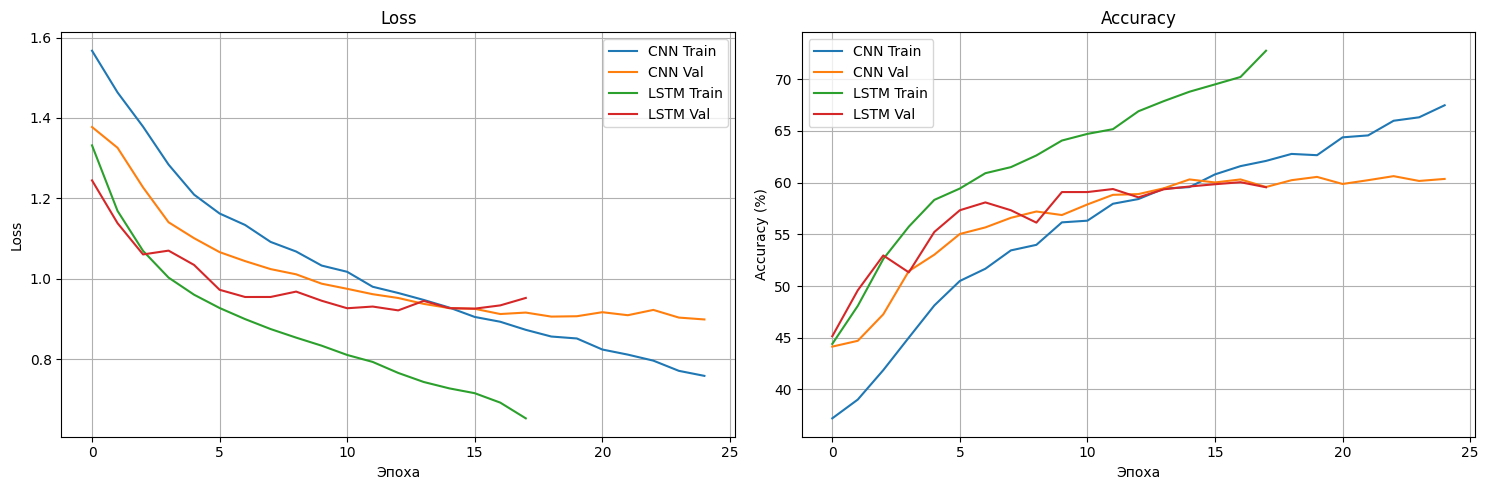

In [21]:
plot_metrics(cnn_results, lstm_results)

# Выводы

- CNN стабильно снижает функцию потерь как на тренировочной, так и на валидационной выборке
- LSTM быстрее снижает функцию потерь на тренировочных данных, но менее стабильно на валидации
- Стоит применить сильнее регуляризацию для LSTM модели и увеличить сложность CNN модели